## PMIM402 Clustering - Suzannah Downie (2131572)


<H2>Introduction</H2>


This notebook will answer within it the questions posed as part of the PMIM402 clustering assessment task. This will enable users to view code and output alongside further information about the process, which should provide a degree of contextual background that will aid users' comprehension of the larger task at hand. Specifically, the questions posed are the following:

<H3>K-Means</H3>

**1.	Why should the attribute “class” in heart-c.csv (“num”) not be included for clustering?**  
**2.	Run the K-means algorithm and provide reasoning for the optimum value of K.**  
**3.	Which features would you expect to be less useful when using K-means and why?**

<H3>Hierarchical Clustering</H3>

**1. Show the clustering results in a tree structure and provide reasoning for the optimal number 
of clusters.**  
**2. Describe the link method you used.**  
**3. What are the strengths and limitations of this link method in hierarchical clustering?**  

These questions will be answered at appropriate points during this notebook. This may mean that they are not necessarily answered in the order specified above, but this is to ensure that they are answered in the context of both code and output that will help to demonstrate the responses in practical terms.

<H2>Data Preparation and Pre-Processing</H2>

The first thing that we need to do is to load in the libraries that we will need for the rest of the notebook. In addition to this, we will also make some tweaks to make our plots more legibile. We will also process the data that we have to get it in to a better format for our clutering tasks.

In [1]:
# Necessary libraries
library(tidyverse)
library(factoextra)
library(dendextend)
library(cluster)
library(clValid)
library(cowplot)

# Make plots more appropriately sized
options(repr.plot.width=15, repr.plot.height=8)


── Attaching packages ─────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


---------------------
Welcome to dendextend version 1.15.2
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPa

In [2]:
# Read in the heart dataset and remove the index column and pipe to data frame.
heart <- read.csv("heart-c.csv")[-1] %>% as.data.frame 

# Create a vector of more meaningful feature names, to enable better comprehension of results.
feature_names = c('age', 'sex', 'chest pain type','resting blood pressure', 
                  'cholesterol','fasting blood sugar','resting ecg', 
                  'max heart rate', 'exercise angina','relative ST depression', 
                  'peak st slope','fluoroscopy result','thallium test result', 'class')

# Replace the existing column names with these values
colnames(heart) <- feature_names

In [3]:
# Check for null values.
colSums(is.na(heart))

age                    sex        chest pain type 
                     0                      0                      0 
resting blood pressure            cholesterol    fasting blood sugar 
                     0                      0                      0 
           resting ecg         max heart rate        exercise angina 
                     0                      0                      0 
relative ST depression          peak st slope     fluoroscopy result 
                     0                      0                      5 
  thallium test result                  class 
                     2                      0

We can see above the number of NA values that exist within our data set, and the feature columns within which these occur. The columns _fluoroscopy result_ and _thallium test result_ contain missing values but other than this we have a relatively complete data set. In addition to this, we should also note the final column, _class_. With this in mind, we might consider the following question:

**1.	Why should the attribute “class” in heart-c.csv (“num”) not be included for clustering?** 
  
We are using an _unsupervised_ algorithm when we use K-Means. This means that the algorithm that does not need any labelled data in order to be effective. With this in mind, we want for the algorithm to make predictions (generate clusters) without access to any labelled data. As “class” is effectively an output we might wish to predict, it is wise not to include this in our model as we want it to be able to predict based on patterns in the data and not the label itself. In a real-world use-case of K-Means, we would not necessarily have access to a label such as this. Because of this, we will remove this from the data. However, we will also retain a version of our heart data frame that contains this, as we might perhaps be able to verify the efficacy of our K-Means model by comparing the cluster predictions for each observation of the data to the class labels within the original data set. This is also known as the **ground truth**.


In [4]:
# Create two data frames - one for K-Means with class removed: 
heart_km <- heart %>% select(-class)

# and one for the ground truth retaining class attribution:
heart_gt <- heart

# View heart data frame so as we can orient ourselves with the dataset at hand.
head(heart_km, 10)

,age,sex,chest pain type,resting blood pressure,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,relative ST depression,peak st slope,fluoroscopy result,thallium test result
,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<chr>
1,63,male,typ_angina,145,233,t,left_vent_hyper,150,no,2.3,down,0,fixed_defect
2,67,male,asympt,160,286,f,left_vent_hyper,108,yes,1.5,flat,3,normal
3,67,male,asympt,120,229,f,left_vent_hyper,129,yes,2.6,flat,2,reversable_defect
4,37,male,non_anginal,130,250,f,normal,187,no,3.5,down,0,normal
5,41,female,atyp_angina,130,204,f,left_vent_hyper,172,no,1.4,up,0,normal
6,56,male,atyp_angina,120,236,f,normal,178,no,0.8,up,0,normal
7,62,female,asympt,140,268,f,left_vent_hyper,160,no,3.6,down,2,normal
8,57,female,asympt,120,354,f,normal,163,yes,0.6,up,0,normal
9,63,male,asympt,130,254,f,left_vent_hyper,147,no,1.4,flat,1,reversable_defect


As we can see above, our data contains a combination of data types:

- Nominal data: sex, chest pain type, fasting blood sugar, resting ecg, exercise angina, peak st slope, fluoroscopy result, thallium test result

- Continuous data: age, resting blood pressure, cholesterol, max heart rate, relative st depression

**3.	Which features would you expect to be less useful when using K-means and why?**  
  
K-Means works by partitioning data and attempting to find the most appropriate mean values for cluster centres (centroids). In doing so it seeks to minimise the intracluster distance using sum of squared errors as a loss function. This aims to reduce the distance between the data points themselves and their respective cluster centroids. As some of our data is nominal, this presents us with the following issues in relation to this objective:

-	We cannot generate a meaningful mean value as the nominal data contains no inherent order.
-	We cannot meaningfully measure the Euclidean distance between data points and cluster centres.
-	As a result of the above, we cannot generate the sum of squared errors to optimise the model.
  
As a result of the above factors, I would expect that the categorical features in this data set would be less useful. To run K-Means effectively we shall remove these from the data set.



In [5]:
# Remove nominal/categorical data
heart_km <- Filter(is.numeric, heart_km) %>% select (-"fluoroscopy result")
head(heart_km)

,age,resting blood pressure,cholesterol,max heart rate,relative ST depression
,<int>,<int>,<int>,<int>,<dbl>
1,63,145,233,150,2.3
2,67,160,286,108,1.5
3,67,120,229,129,2.6
4,37,130,250,187,3.5
5,41,130,204,172,1.4
6,56,120,236,178,0.8


Next we can display this continuous data as histograms. This gives us an insight in to the underlying distribution of the data before we create any clusters.

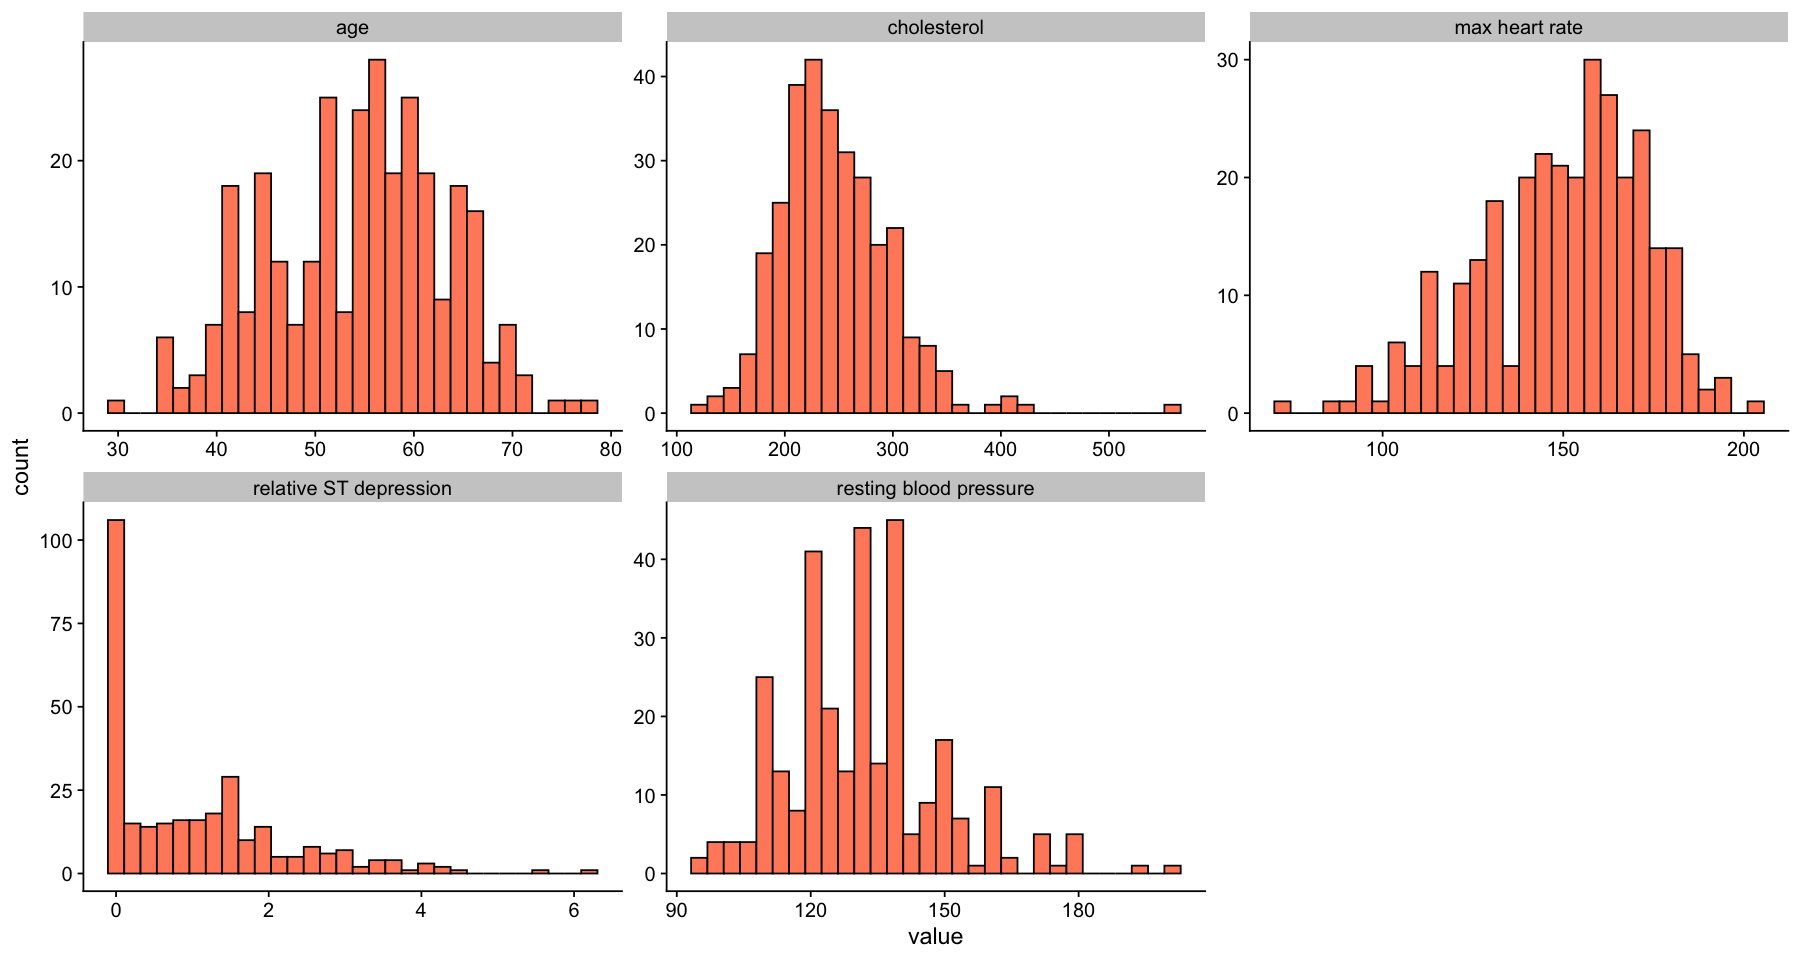

In [6]:
# gather the data frame in long format and then plot as histogram
heart_km %>% gather(attribute, value, 1:ncol(heart_km)) %>%
  ggplot(aes(x = value)) + 
  geom_histogram(fill = "salmon1", color = "black", bins = 30) +
  facet_wrap(~attribute, scales = 'free') +
  theme_cowplot()

Next we need to scale the remaining continuous data so as each feature's data sits within a similar range

In [7]:
# Scale the data
heart_norm <- scale(heart_km) %>% as.data.frame

<H2>K-Means</H2>

**2. Run the K-means algorithm and provide reasoning for the optimum value of K.**  

As K-Means works by assigning the value of $k$, we need to consider ways to determine the optimal number of clusters ($k$) within our data set. Firstly we will create an elbow plot to show how the within cluster sum of squares changes based upon the number of clusters. Ideally the plot will give us a clear 'elbow' at the point of optimum clusters.

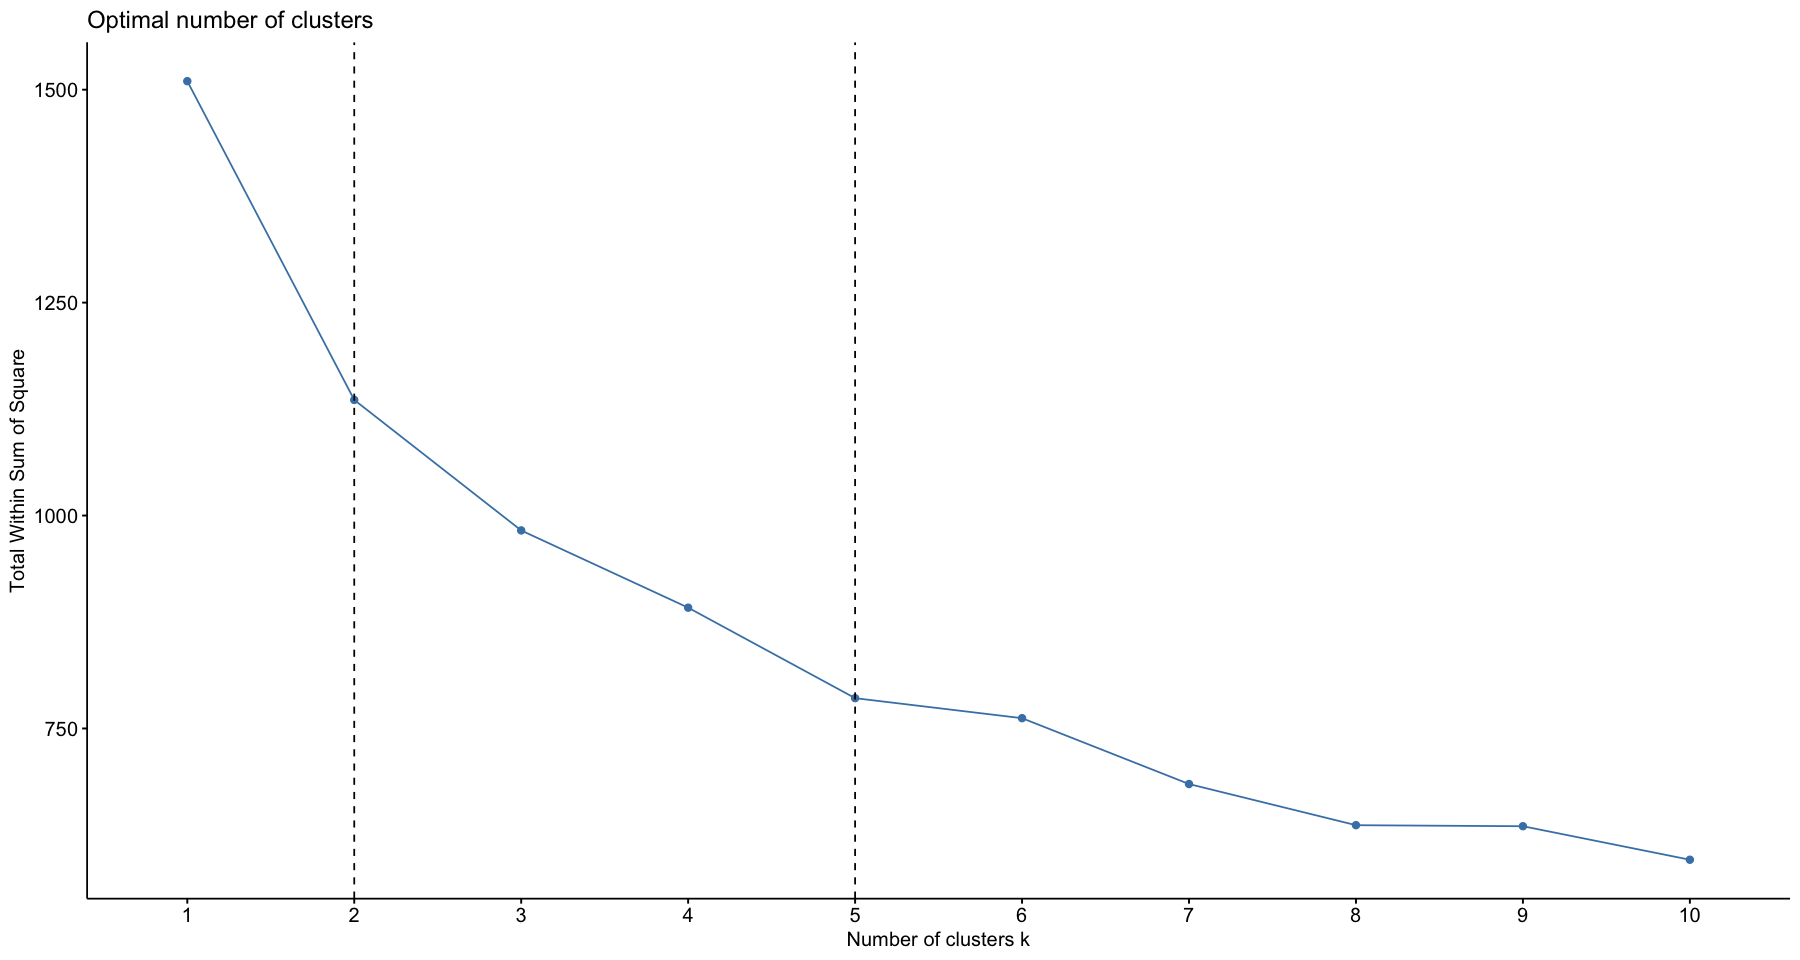

In [8]:
# Create elbow plot for clusters 1:10
fviz_nbclust(x = heart_norm, FUNcluster = kmeans, method = "wss") +
  geom_vline(xintercept = 2, linetype = 2) +  # add vertical dotted line to 2
  geom_vline(xintercept = 5, linetype = 2) # add vertical dotted line to 5

The above elbow plot is not as definitive as it could be, and the elbow is likely to be at one of two points, 2 or 5. We can also see that after 5 clusters the plot levels off and we can see diminishing returns. As this is the case, we should attempt to supplement this plot with alternative methods to gain better clarity as to how many clusters we need. One such method is to determine the silhouette score. This is a measure of the similarity that a particular data point has to it's own cluster and whether it is badly matched to other clusters.

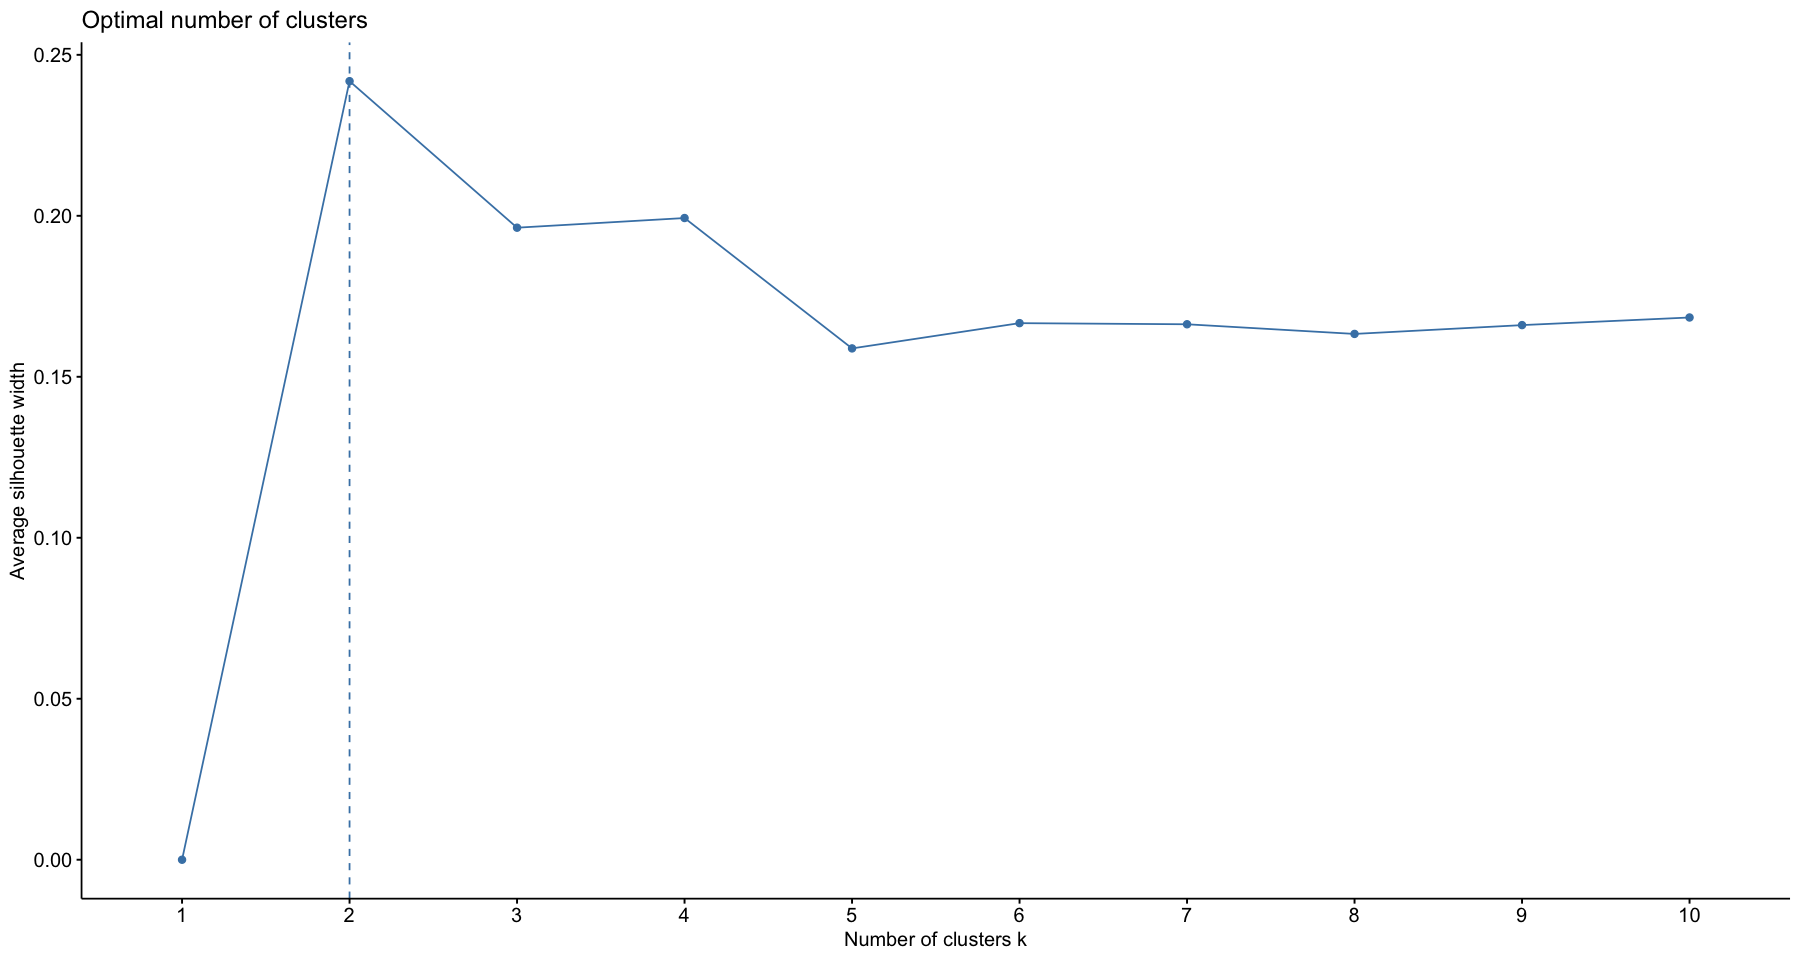

In [9]:
# Silhouette score
fviz_nbclust(x = heart_norm, FUNcluster = kmeans, method = 'silhouette')

As we can see above, this plot is much more definitive, with the silhouette score sitting at 0.25 for 2 clusters between possible values of 1 (high fidelity silhouette) and -1 (low fidelity silhouette). Given this information, it is likely at this point that the initial optimum number of clusters is 2. For this reason we will create a K-Means model with a value of $k$ = 2. However, to ensure that we are being as thorough as possible, we can also run K-Means for 3, 4, and 5 clusters and view this to see how effective this has been.

In [10]:
# Run K-Means across 2:5 clusters and store the results for further analysis. 
# number of times to run before returning result is set at 50 (iter.max)
# attempt 10 different initialisations (nstart)
kmeans_res <- lapply(2:5, function(i) kmeans(heart_norm, i, iter.max = 50, nstart = 10)) 
                     
names(kmeans_res) <- paste0("cluster", 2:5) #label each set of results

Now that we have results for each value of $k$ it is possible to view the results.

In [11]:
kmeans_res$cluster2 # View results when k = 2 clusters

K-means clustering with 2 clusters of sizes 172, 131

Cluster means:
         age resting blood pressure cholesterol max heart rate
1 -0.5415776             -0.3355766  -0.2416645      0.5202796
2  0.7110790              0.4406044   0.3173000     -0.6831152
  relative ST depression
1             -0.4537289
2              0.5957356

Clustering vector:
  [1] 2 2 2 1 1 1 2 1 2 2 1 2 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 2 1 1 2 1 2 1 1 1 1
 [38] 2 2 2 2 1 2 2 1 1 1 2 2 1 1 1 1 1 2 2 1 1 1 2 2 1 2 1 2 2 2 1 2 2 2 1 2 1
 [75] 1 2 2 2 1 2 1 1 1 2 1 1 1 1 1 1 2 2 2 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2 1 2
[112] 2 1 2 2 1 1 1 2 2 1 2 1 2 2 1 2 2 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2 1 1 2 1
[149] 1 1 1 1 2 2 2 2 1 1 2 2 1 2 1 2 1 1 1 1 1 1 2 2 2 2 2 2 1 2 1 1 1 2 1 2 1
[186] 1 2 1 2 1 2 1 2 2 2 2 1 1 2 1 2 1 2 1 1 2 2 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1
[223] 2 1 1 1 2 1 2 1 2 1 2 1 2 2 1 1 1 1 1 1 2 2 2 1 1 1 1 2 2 2 1 1 1 1 2 2 1
[260] 1 2 1 1 2 2 1 2 1 1 2 2 2 2 1 2 2 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 2
[297] 2

In [12]:
kmeans_res$cluster4 # View results when k = 4 clusters

K-means clustering with 4 clusters of sizes 38, 122, 78, 65

Cluster means:
         age resting blood pressure cholesterol max heart rate
1  0.6232015              0.7656951   0.1792103     -0.5682250
2 -0.8444759             -0.4519886  -0.3428896      0.6570509
3  0.6273621              0.6062585   0.7223724      0.2980767
4  0.4678486             -0.3267994  -0.3280386     -1.2587329
  relative ST depression
1              1.8765515
2             -0.4541557
3             -0.3344503
4              0.1566949

Clustering vector:
  [1] 1 1 4 2 2 2 1 3 3 1 4 3 3 2 3 2 2 3 2 2 4 3 3 1 4 2 3 1 2 4 3 2 3 3 2 2 4
 [38] 4 3 3 4 2 3 3 3 2 4 1 3 2 2 4 2 2 4 4 2 2 3 4 3 2 4 3 4 1 1 3 1 1 3 3 4 3
 [75] 2 3 1 3 2 4 2 3 2 3 3 2 2 4 2 2 3 1 4 2 3 2 4 1 2 2 2 2 3 4 4 2 2 2 1 2 3
[112] 4 2 1 4 2 3 2 3 1 2 1 2 1 3 2 1 4 2 2 2 2 2 2 2 3 1 4 2 2 3 3 2 4 2 2 3 2
[149] 2 3 3 2 3 3 4 1 3 3 3 3 2 3 2 4 2 2 2 3 2 2 1 4 3 3 1 4 2 4 2 2 2 3 2 1 3
[186] 2 3 3 1 2 1 2 4 4 4 3 2 2 3 2 3 2 3 2 3 1 4 3 3 2 2 2 3 2 

Now that we have results for each cluster, one way to continue to assess the efficacy of a given cluster ($k$) is to visualise the results. Given that we have removed the categorical data, our data currently has 5 features (_age, resting blood pressure, cholesterol, max heart rate, relative st depression_). Thus, our data is **_5 dimensional_**. This is too many dimensions to view meaningfully at once. As a result of this we need to reduce the dimensionality of our data in order to visualise our results in a **_2 dimensional_** space (i.e on an $x$ and $y$ axis). R has a set of cluster visualisation tools that can help us with this. These use **_Principal Component Analysis (PCA)_** to reduce the dimensions of our data so as we can view this in a 2 dimensional space.

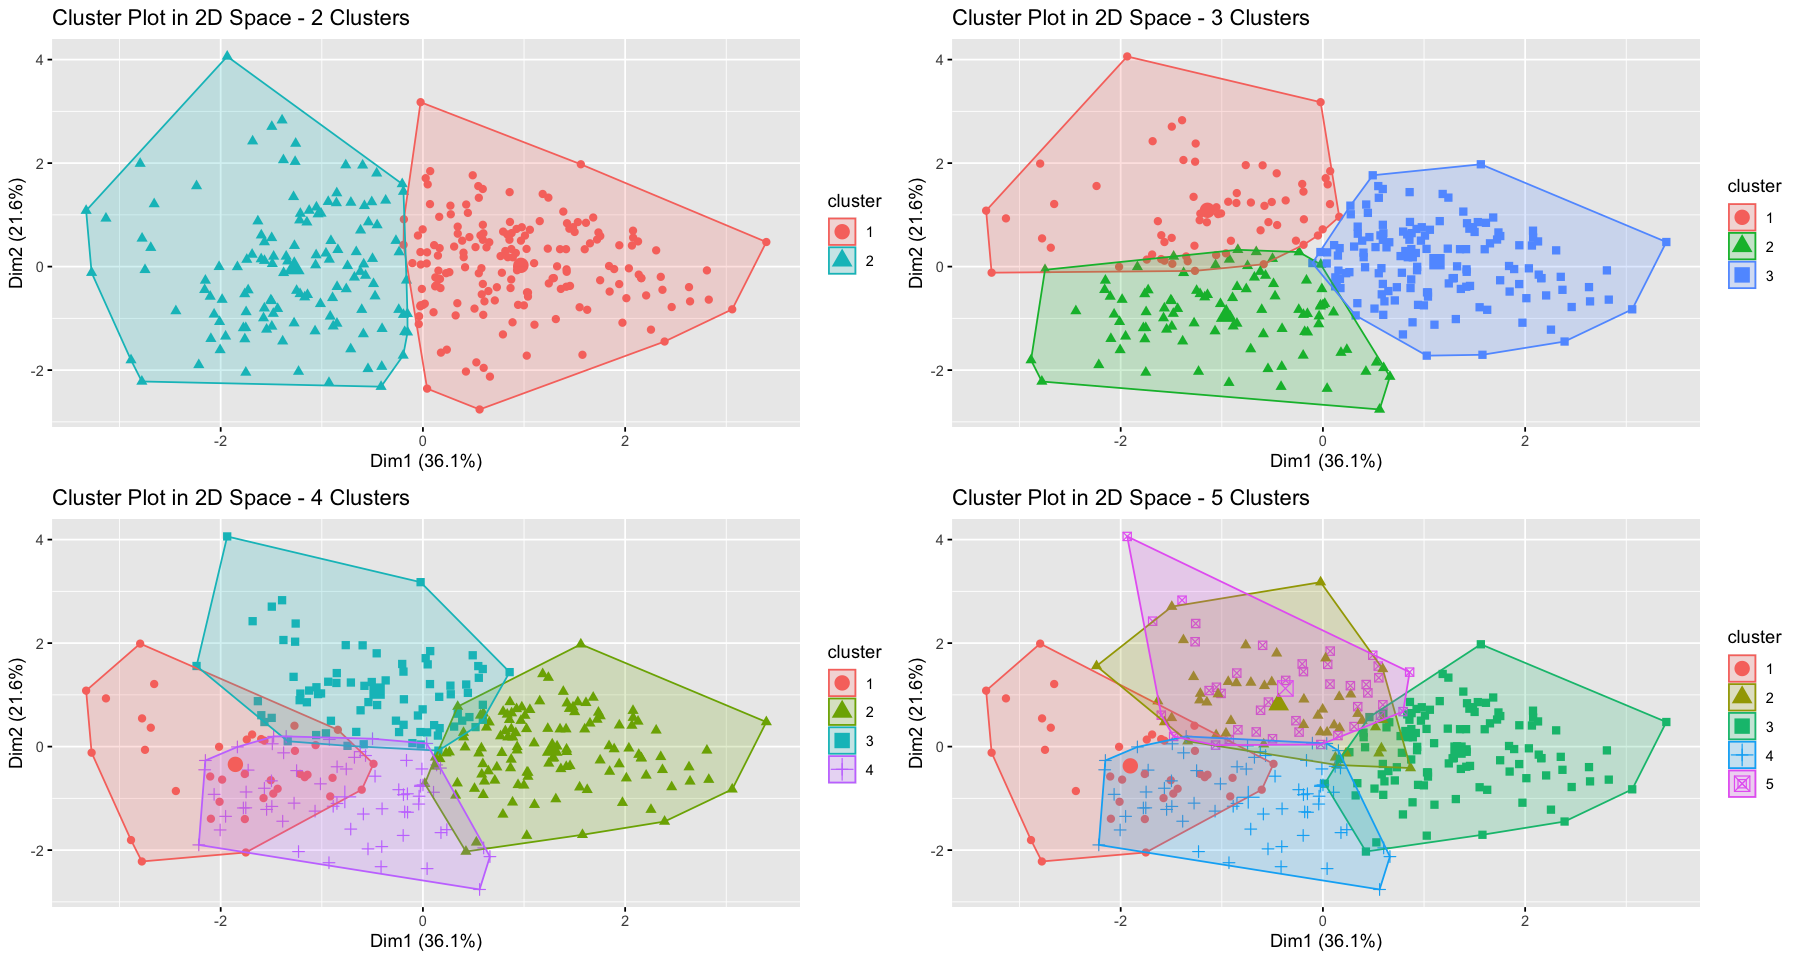

In [13]:
# Create visualisations for all results
visualise_2_clusters <- fviz_cluster(kmeans_res$cluster2, geom = "point", pointsize = 2, 
             data = heart_norm, 
             main = 'Cluster Plot in 2D Space - 2 Clusters')

visualise_3_clusters <- fviz_cluster(kmeans_res$cluster3, geom = "point", pointsize = 2, 
             data = heart_norm, 
             main = 'Cluster Plot in 2D Space - 3 Clusters')

visualise_4_clusters <- fviz_cluster(kmeans_res$cluster4, geom = "point", pointsize = 2, 
             data = heart_norm, 
             main = 'Cluster Plot in 2D Space - 4 Clusters')

visualise_5_clusters <- fviz_cluster(kmeans_res$cluster5, geom = "point", pointsize = 2, 
             data = heart_norm, 
             main = 'Cluster Plot in 2D Space - 5 Clusters')

# Store these in a list of all plots, so as can be visualised as a group output
all_plots <- list(visualise_2_clusters, visualise_3_clusters, visualise_4_clusters, visualise_5_clusters)

# USe Cowplot's plot_grid to display as group with subplots
plot_grid(plotlist = all_plots)

Ideally with K-Means we are aiming to maximise the distance between clusters. Therefore, it is sensible to seek a value of $k$ where there is a degree of separation between the clusters when we visualise in this way. This most certainly rules out $k$ = 4 and $k$ = 5. It also rules out $k$ = 3, although this does appear to be vastly superior to 4 and 5 clusters. Given that the elbow plot and silhouette plot suggested 2 as the initial optimum number of clusters, and given that the clusters for $k$ = 2 seem to be well defined and separated, I would argue that the most appropriate value of $k$ is:  
<H3 align = "center">$k$ = 2</H3>

It might also be interesting to re-plot our histogram so as we might see cluster membership in this way. To do so we need to add each data point's cluster membership to our data frame.

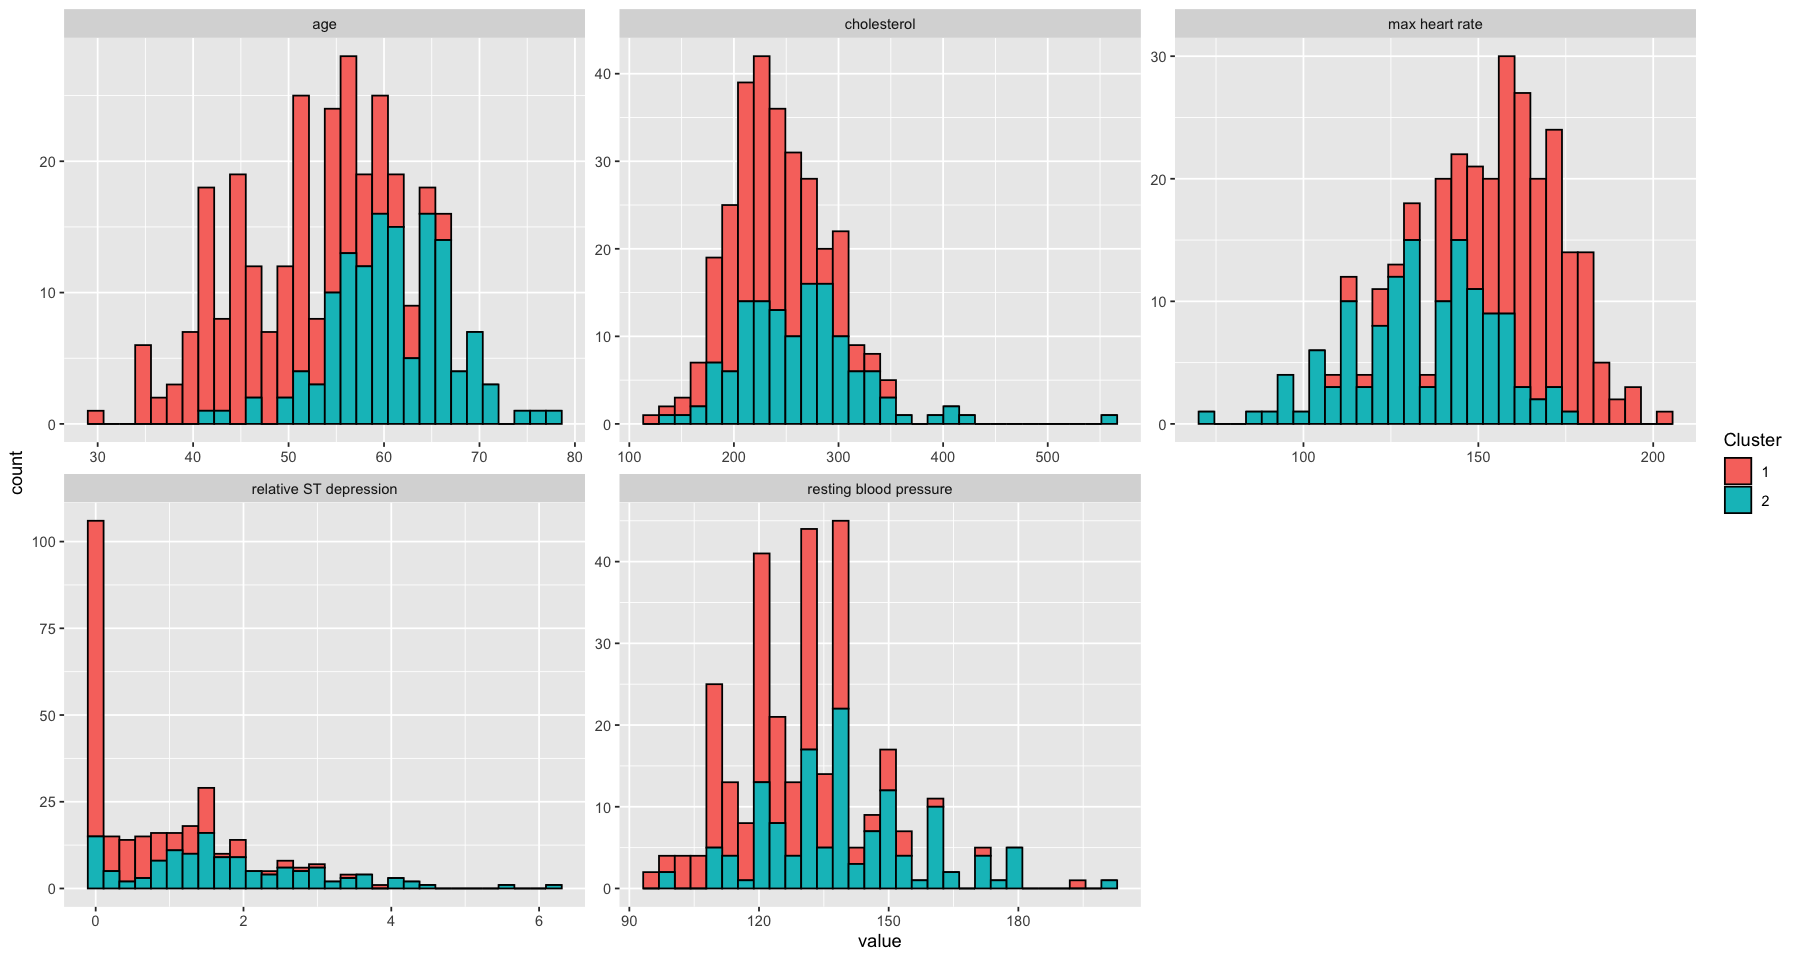

In [14]:
#  add cluster labels to the dataframe as factors
heart_clust_labels <- cbind(heart_km, 'Cluster' = kmeans_res$cluster2$cluster)
heart_clust_labels$Cluster <- as.factor(heart_clust_labels$Cluster)


# Re-plot histogram and group by cluster membership
heart_clust_labels %>% gather(attribute, value, 1:ncol(heart_clust_labels)-1) %>%
  ggplot(aes(x = value, group = Cluster, fill = Cluster)) + 
  geom_histogram(bins = 30, color = 'black') +
  facet_wrap(~attribute, scales = 'free') +
  theme_grey()

Viewing the data grouped in this way enables us to gain greater insight in to our data based on cluster membership. For example, we can see from these histograms that cluster 2 are older than cluster 1. We can also see that they have greater instances of higher cholesterol, and a lower max heart rate.

<H2>Hierarchical Clustering</H2>

Hierarchical clustering is another form of clustering that differs from K-Means in that we do not need to specify the value of $k$. It is possible to use this form of clustering in one of two ways:

**Divisive hierarchical clustering**  
Divisive hierarchical clustering works by placing all data points within one homogeneous cluster. These are then divided in two based upon the clusterings that are deemed most heterogeneous.

**Agglomerative hierarchical clustering**  
Agglomerative hierarchical clustering works on the basis that all data points begin as individual clusters. These clusters are then grouped together based on the distance to other clusters. There are multiple ways to define how these groups are formed and this is often known as the linkage method, however all are based on the measurement of the Euclidean distance between points.

In this notebook we will use Agglomerative clustering. With this in mind, we should consider the various linkage methods.

**Linkage methods**  
- **Complete linkage:** 
- **Single linkage:** 
- **Average linkage:** 
- **Centroid linkage:** 
- **Ward’s method:** 



In [15]:
# create distance matrix
# a matrix for use with fviz_nbclust
dist_1 <- dist(heart_norm, method = "euclidean") %>% as.matrix(dist_1)

In [16]:
# a vector for use with hclust
dist_2 <- dist(heart_norm, method = 'euclidean')

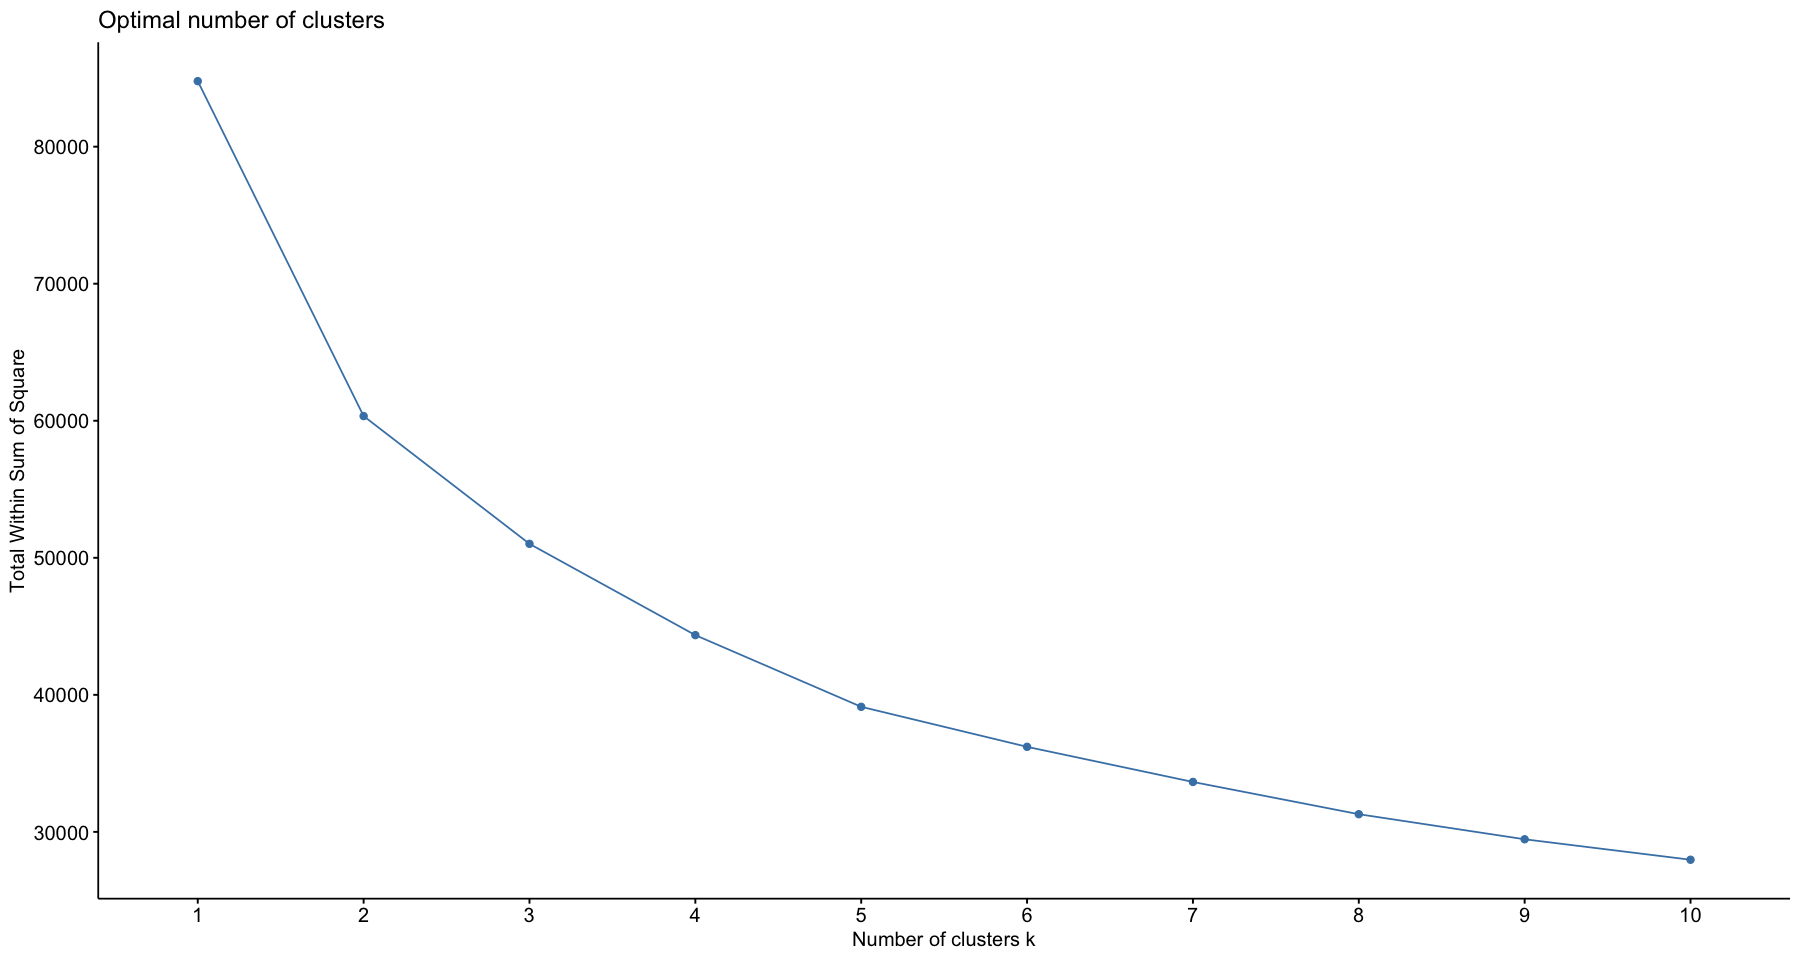

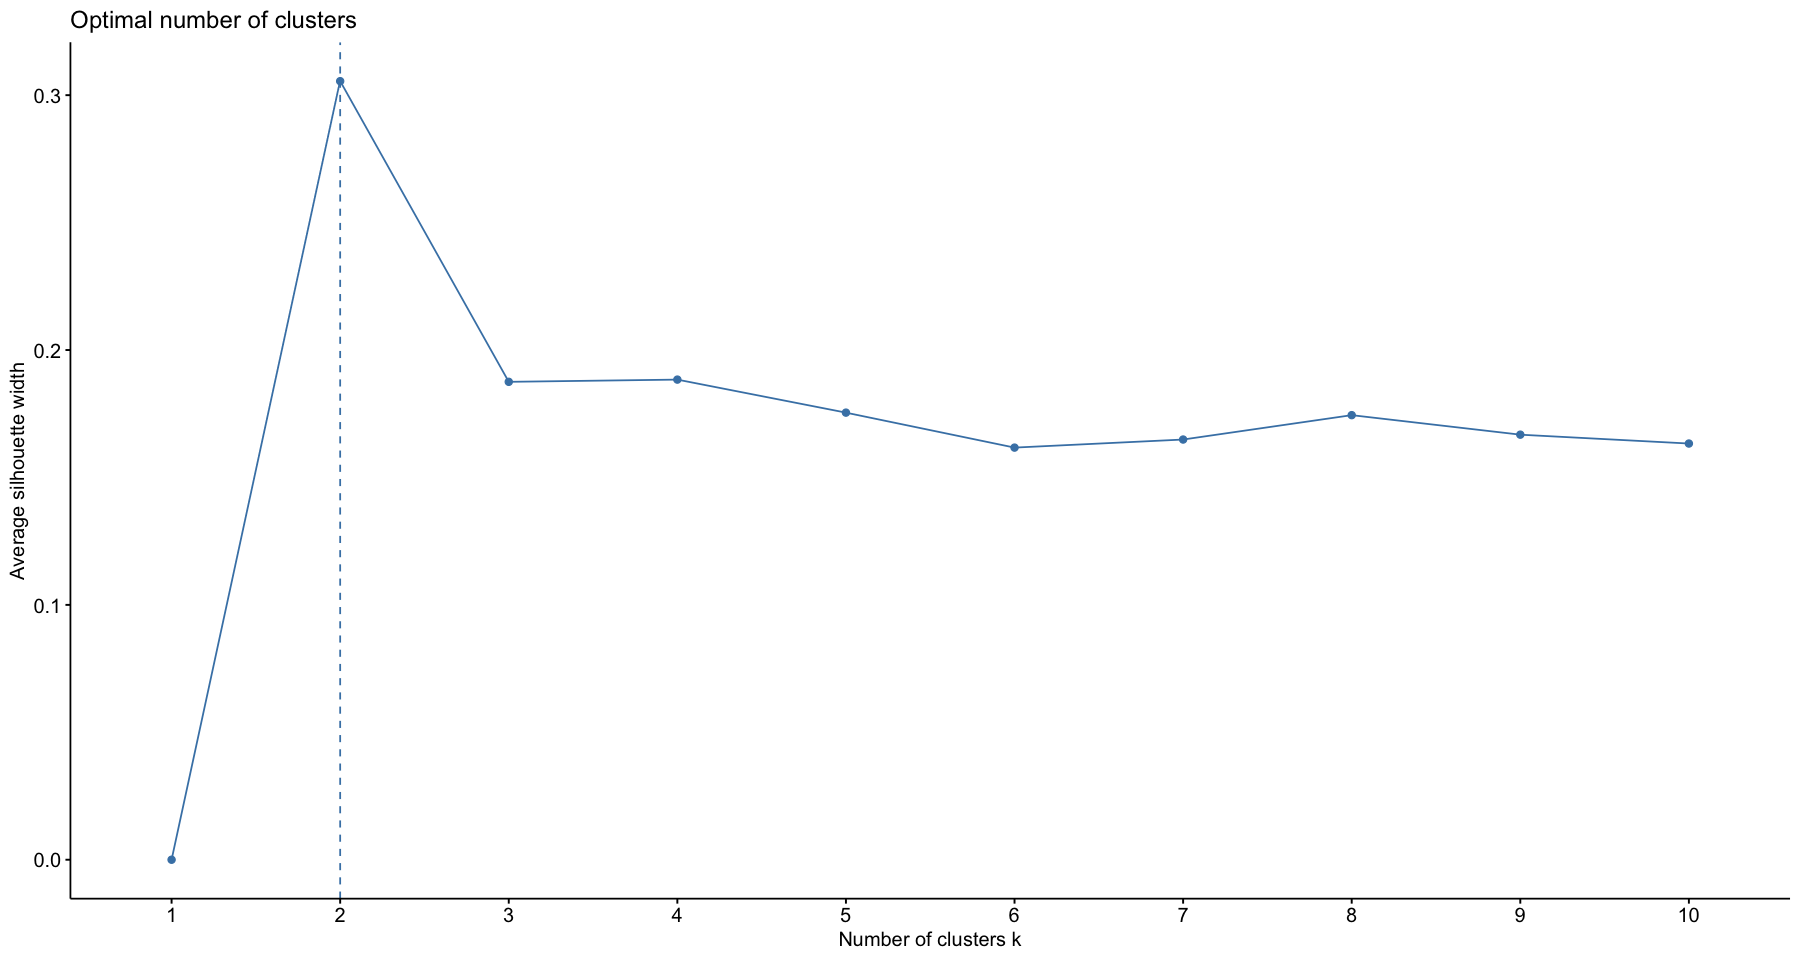

In [17]:
# use fviz_nbclust to view initial optimal clusters and silhouette plot
fviz_nbclust(x = dist_1, FUNcluster = hcut, method = "wss")
fviz_nbclust(x = dist_1, FUNcluster = hcut, method = 'silhouette')

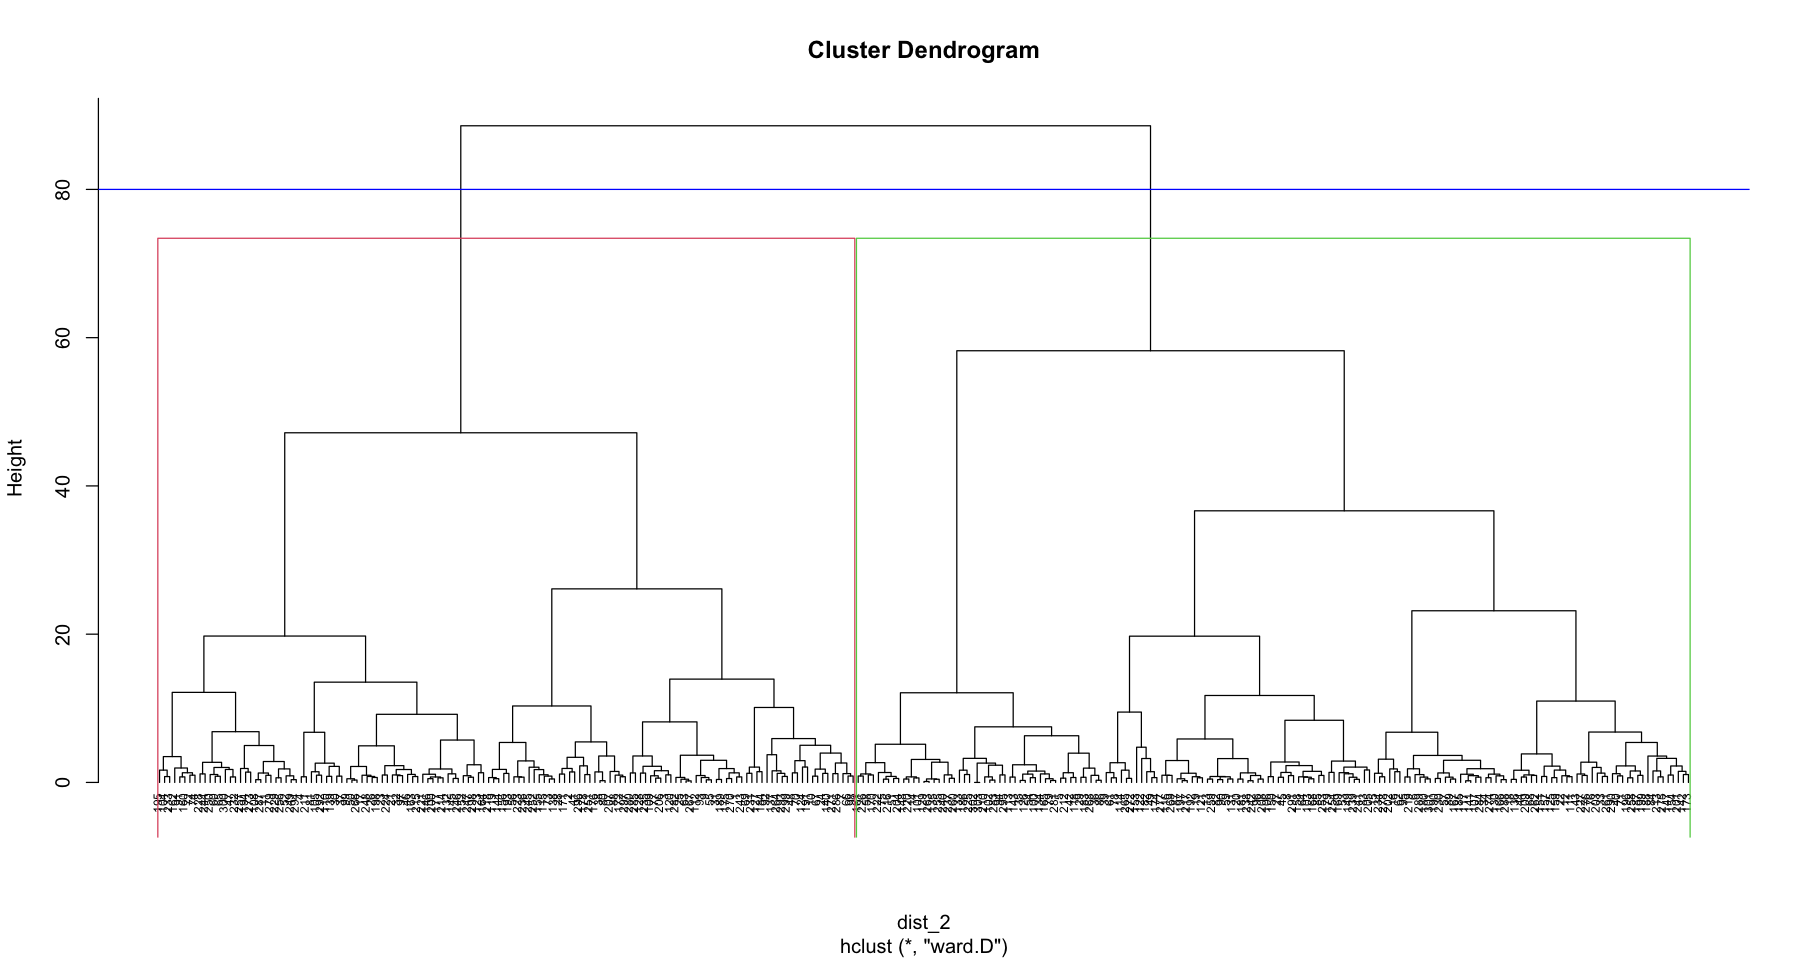

In [18]:
# Create hierarchical cluster model and plot
hir_clust <- hclust(dist_2, method = 'ward.D') 
plot(hir_clust, cex = 0.6, hang = -1) 
rect.hclust(hir_clust, k = 2, border = 2:6)
abline(h = 80, col = 'blue')

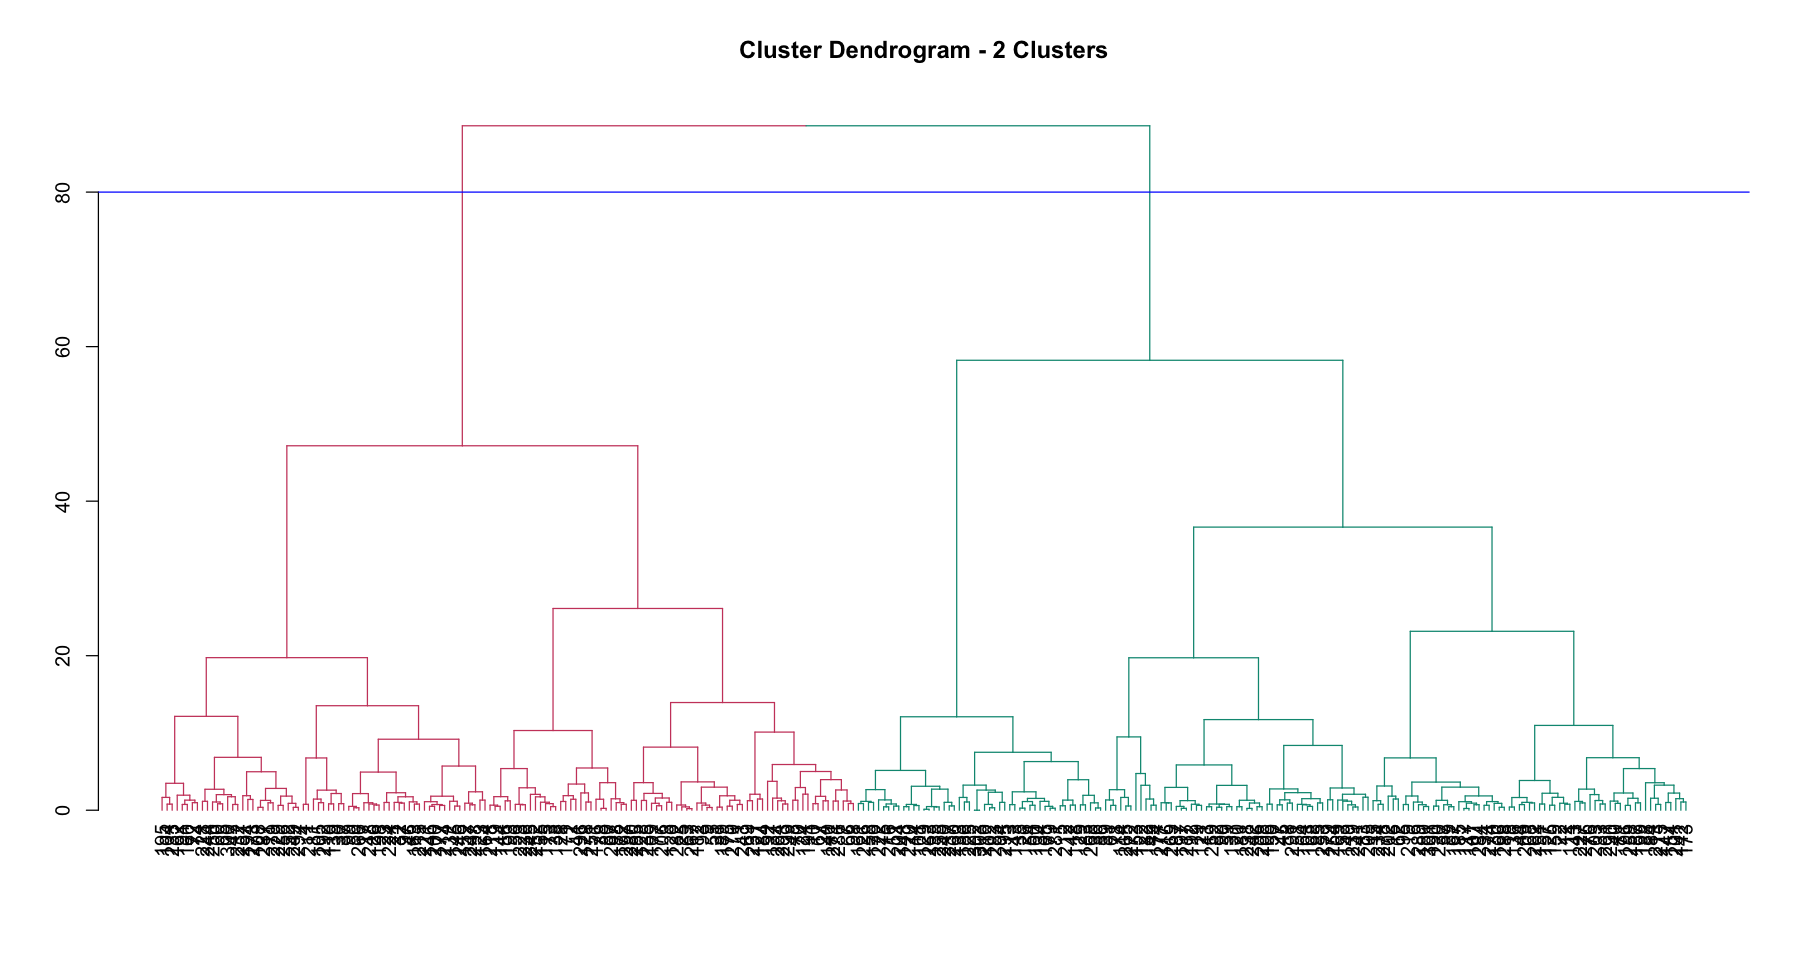

In [19]:
# plot hierarchical cluster with colour branches
hir_dend <- as.dendrogram(hir_clust)
plot(color_branches(hir_dend, k = 2), main = 'Cluster Dendrogram - 2 Clusters')
abline(h = 80, col = 'blue')

In [20]:
cluster <- cutree(hir_clust, 2)
dunn(dist_2, cluster)

[1] 0.06909261